# Final Bidirectional LSTM Model for RUL Prediction (All Datasets)

This notebook contains the final, most powerful model architecture. It trains a single Bidirectional LSTM on all four datasets to create a robust, generalized model for predicting engine degradation.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

DATA LOADING


In [2]:
# Define column names
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

# --- Load and combine all training data ---
train_data_list = []
for i in range(1, 5):
    df = pd.read_csv(f'train_FD00{i}.txt', sep=" ", header=None)
    df.drop(columns=[26, 27], inplace=True)
    df.columns = columns
    df['dataset'] = f'FD00{i}'
    train_data_list.append(df)
train_data = pd.concat(train_data_list, ignore_index=True)

# Calculate Life Ratio for training data
max_cycles_train = train_data.groupby(['dataset', 'unit_number'])['time_in_cycles'].transform('max')
train_data['life_ratio'] = train_data['time_in_cycles'] / max_cycles_train

# --- Load and combine all test data ---
test_data_list = []
for i in range(1, 5):
    df = pd.read_csv(f'test_FD00{i}.txt', sep=" ", header=None)
    df.drop(columns=[26, 27], inplace=True)
    df.columns = columns
    df['dataset'] = f'FD00{i}'
    test_data_list.append(df)
test_data = pd.concat(test_data_list, ignore_index=True)

# --- Load and combine all RUL ground truth data ---
truth_data_list = []
for i in range(1, 5):
    df = pd.read_csv(f'RUL_FD00{i}.txt', sep=" ", header=None)
    df.drop(columns=[1], inplace=True)
    df.index = df.index + 1
    df.columns = ['true_RUL']
    df['dataset'] = f'FD00{i}'
    df['unit_number'] = df.index
    truth_data_list.append(df)
truth_data = pd.concat(truth_data_list, ignore_index=True)

# Calculate Life Ratio for test data
test_data = pd.merge(test_data, truth_data, on=['dataset', 'unit_number'])
max_cycles_test = test_data.groupby(['dataset', 'unit_number'])['time_in_cycles'].transform('max')
total_life_test = max_cycles_test + test_data['true_RUL']
test_data['life_ratio'] = test_data['time_in_cycles'] / total_life_test

print("All datasets loaded and prepared successfully.")
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)  

All datasets loaded and prepared successfully.
Training data shape: (160359, 28)
Test data shape: (104897, 29)


In [3]:
# Identify feature columns to scale
feature_cols = ['setting_1', 'setting_2', 'TRA', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'W31', 'W32']

scaler = StandardScaler()
train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
test_data[feature_cols] = scaler.transform(test_data[feature_cols])

print("Features scaled.")

Features scaled.


In [4]:
# Using the best sequence length we found
SEQUENCE_LENGTH = 70

def create_sequences(input_data, sequence_length):
    sequences, labels = [], []
    # Group by dataset AND unit number to handle engines correctly
    for _, group in input_data.groupby(['dataset', 'unit_number']):
        features = group[feature_cols].values
        label_data = group['life_ratio'].values
        for i in range(len(features) - sequence_length + 1):
            sequences.append(features[i:i+sequence_length])
            labels.append(label_data[i+sequence_length-1])
    return np.array(sequences), np.array(labels)

X_train, y_train = create_sequences(train_data, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(test_data, SEQUENCE_LENGTH)

print(f"Using Sequence Length: {SEQUENCE_LENGTH}")
print(f"Training sequences shape: {X_train.shape}")
print(f"Test sequences shape: {X_test.shape}")

Using Sequence Length: 70
Training sequences shape: (111438, 70, 17)
Test sequences shape: (58432, 70, 17)


In [5]:
class RULDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx].unsqueeze(-1)

train_loader = DataLoader(RULDataset(X_train, y_train), batch_size=256, shuffle=True)
test_loader = DataLoader(RULDataset(X_test, y_test), batch_size=256, shuffle=False)

In [6]:
# --- The Final Upgrade: A Bidirectional LSTM Model ---
class BiLSTMRULModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(BiLSTMRULModel, self).__init__()
        self.lstm = nn.LSTM(input_size, 
                              hidden_size, 
                              num_layers, 
                              batch_first=True, 
                              dropout=dropout_prob,
                              bidirectional=True) # The key upgrade is here!
        
        # The input to the fully connected layer is now twice the hidden size
        # because the LSTM is bidirectional (hidden_size from forward + hidden_size from backward)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3) # Add dropout here for regularization
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :]) # Use the output of the last time step
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [7]:
# --- Training the Bidirectional LSTM ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Final Hyperparameters ---
INPUT_SIZE = len(feature_cols)
HIDDEN_SIZE = 128
NUM_LAYERS = 2 # 2 bidirectional layers is very powerful
DROPOUT = 0.3 # A bit more dropout for this bigger model
LEARNING_RATE = 0.001
EPOCHS = 30

# --- Initialize Model ---
# IMPORTANT: Use the new BiLSTMRULModel class
model = BiLSTMRULModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)

# --- Optimizer and Scheduler ---
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# --- Training Loop ---
criterion = nn.MSELoss()
best_rmse = float('inf')
print("Starting final training run with Bidirectional LSTM...")

for epoch in range(EPOCHS):
    model.train()
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    all_preds = []
    with torch.no_grad():
        for sequences, _ in test_loader:
            all_preds.append(model(sequences.to(device)).cpu().numpy())
            
    preds = np.concatenate(all_preds).flatten()
    test_rmse = np.sqrt(np.mean((preds - y_test)**2))
    
    scheduler.step()
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.6f}, Test RMSE: {test_rmse:.6f}')
    
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        torch.save(model.state_dict(), 'best_bidirectional_model.pth')
        print(f'---> New best model saved with RMSE: {best_rmse:.6f}')

print(f"\nTraining finished. Best Test RMSE: {best_rmse:.6f}")

Starting final training run with Bidirectional LSTM...
Epoch [1/30], Loss: 0.010872, Test RMSE: 0.124980
---> New best model saved with RMSE: 0.124980
---> New best model saved with RMSE: 0.113639
---> New best model saved with RMSE: 0.096355
Epoch [5/30], Loss: 0.005651, Test RMSE: 0.084166
---> New best model saved with RMSE: 0.084166
---> New best model saved with RMSE: 0.083929
Epoch [10/30], Loss: 0.006151, Test RMSE: 0.085396
---> New best model saved with RMSE: 0.082465
---> New best model saved with RMSE: 0.081224
Epoch [15/30], Loss: 0.002356, Test RMSE: 0.083001
---> New best model saved with RMSE: 0.079973
Epoch [20/30], Loss: 0.001767, Test RMSE: 0.081390
Epoch [25/30], Loss: 0.001800, Test RMSE: 0.081096
---> New best model saved with RMSE: 0.079950
---> New best model saved with RMSE: 0.079906
Epoch [30/30], Loss: 0.001563, Test RMSE: 0.079859
---> New best model saved with RMSE: 0.079859

Training finished. Best Test RMSE: 0.079859


In [8]:
# Load the best performing model
model.load_state_dict(torch.load('best_bidirectional_model.pth'))
model.to(device)
model.eval()

# Generate predictions
y_pred_list = []
with torch.no_grad():
    for sequences, _ in test_loader:
        y_pred_list.append(model(sequences.to(device)).cpu().numpy())

y_pred = np.concatenate(y_pred_list).flatten()

# --- Calculate All Metrics ---
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
custom_accuracy = np.mean(np.abs(y_pred - y_test) < 0.10) * 100

print(f"--- Final Model Performance on ALL Datasets ---")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Accuracy (within ±10% of total life): {custom_accuracy:.2f}%")

C:\Users\rsree\AppData\Local\Temp\ipykernel_480\1385430290.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_bidirectional_model.pth

--- Final Model Performance on ALL Datasets ---
R-squared (R²) Score: 0.8005
Root Mean Squared Error (RMSE): 0.079859
Mean Absolute Error (MAE): 0.057711
Accuracy (within ±10% of total life): 82.15%


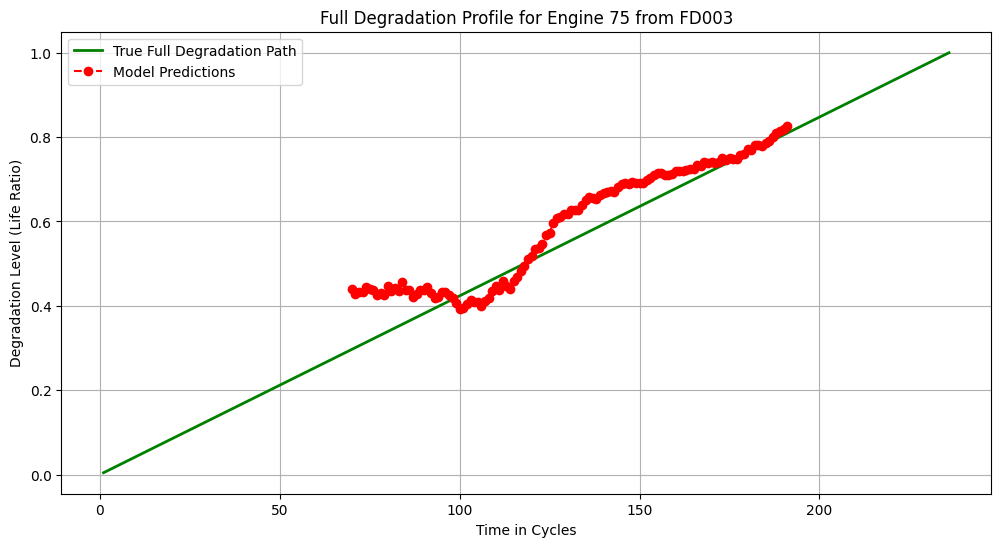

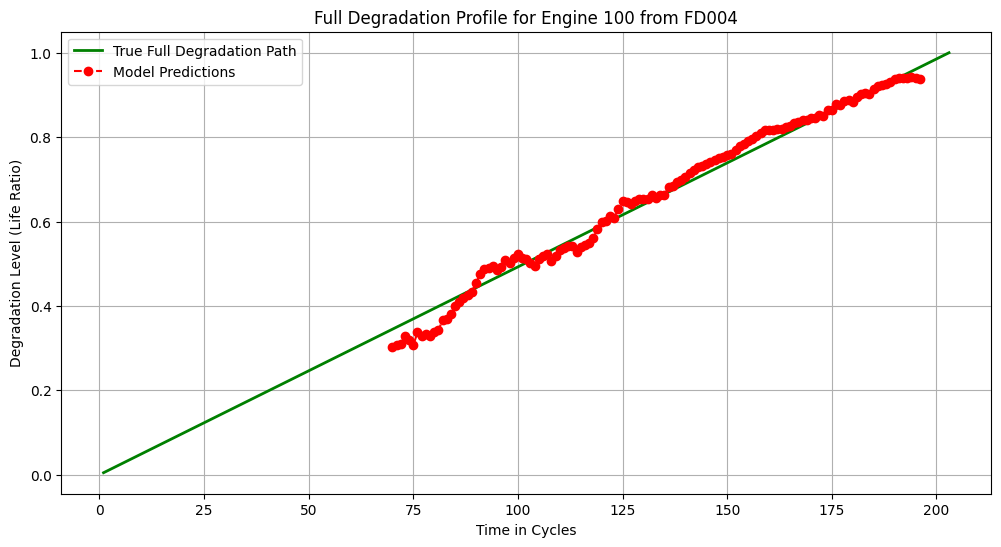

In [9]:
def plot_engine_profile(dataset_id, unit_id, model, test_dataframe):
    engine_data = test_dataframe[(test_dataframe['dataset'] == dataset_id) & (test_dataframe['unit_number'] == unit_id)]
    
    if engine_data.empty:
        print(f"No data found for Dataset {dataset_id}, Unit {unit_id}")
        return

    # Calculate the engine's total lifetime
    last_cycle_in_test = engine_data['time_in_cycles'].iloc[-1]
    true_rul_at_end = engine_data['true_RUL'].iloc[-1]
    total_engine_life = last_cycle_in_test + true_rul_at_end

    # Create the "True Degradation" line for the full life
    full_x_axis = np.arange(1, total_engine_life + 1)
    full_y_axis = full_x_axis / total_engine_life

    # Get the model's predictions for this engine
    engine_sequences, _ = create_sequences(engine_data, SEQUENCE_LENGTH)
    
    if len(engine_sequences) == 0:
        print(f"Not enough data to create sequence for Unit {unit_id}")
        return
        
    engine_sequences_tensor = torch.tensor(engine_sequences, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        engine_preds = model(engine_sequences_tensor).cpu().numpy().flatten()
    
    prediction_x_axis = engine_data['time_in_cycles'].values[SEQUENCE_LENGTH-1:]

    # Plot everything
    plt.figure(figsize=(12, 6))
    plt.plot(full_x_axis, full_y_axis, label='True Full Degradation Path', color='green', linewidth=2)
    plt.plot(prediction_x_axis, engine_preds, label='Model Predictions', color='red', linestyle='--', marker='o')
    
    plt.title(f'Full Degradation Profile for Engine {unit_id} from {dataset_id}')
    plt.xlabel('Time in Cycles')
    plt.ylabel('Degradation Level (Life Ratio)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Plot an example engine from each dataset to see performance ---
plot_engine_profile('FD003', 75, model, test_data)
plot_engine_profile('FD004', 100, model, test_data)